In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from patsy.highlevel import dmatrix

In [2]:
df = pd.read_csv("Card and Krueger.csv")
df = df.apply(pd.to_numeric, errors='coerce')

In [3]:
df

,sheet,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,firstin2,special2,meals2,open2r,hrsopen2,psoda2,pfry2,pentree2,nregs2,nregs112
0,46,1,0,0,0,0,0,1,0,0,...,0.08,1.0,2.0,6.5,16.5,1.03,NaN,0.94,4.0,4.0
1,49,2,0,0,0,0,0,1,0,0,...,0.05,0.0,2.0,10.0,13.0,1.01,0.89,2.35,4.0,4.0
2,506,2,1,0,0,0,0,1,0,0,...,0.25,NaN,1.0,11.0,11.0,0.95,0.74,2.33,4.0,3.0
3,56,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,0.92,0.79,0.87,2.0,2.0
4,61,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,1.01,0.84,0.95,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,423,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,11.0,1.05,0.84,2.32,3.0,2.0
406,424,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,14.0,1.05,0.94,2.32,5.0,3.0
407,426,3,1,1,0,0,1,0,0,0,...,0.25,1.0,2.0,6.0,18.0,1.11,1.05,1.05,6.0,5.0
408,427,4,0,1,0,0,1,0,0,0,...,NaN,1.0,2.0,10.5,12.5,1.11,1.09,2.07,2.0,2.0


In [4]:
df['pre_fte'] = df['empft'] + df['nmgrs'] + (0.5 * df['emppt'])
df['post_fte'] = df['empft2'] + df['nmgrs2'] + (0.5 * df['emppt2'])
df['delta_fte'] = df['post_fte'] - df['pre_fte']
df['gap'] = np.where((df['state'] == 1) & (df['wage_st'] < 5.05), (5.05 - df['wage_st']) / df['wage_st'], 0)
df['chain1'] = np.where(df['chain'] == 1, 1, 0)
df['chain2'] = np.where(df['chain'] == 2, 1, 0)
df['chain3'] = np.where(df['chain'] == 3, 1, 0)
df['chain4'] = np.where(df['chain'] == 4, 1, 0)

In [5]:
df.describe()

,sheet,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,nregs2,nregs112,pre_fte,post_fte,delta_fte,gap,chain1,chain2,chain3,chain4
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,388.000000,383.000000,398.000000,396.000000,384.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,246.507317,2.117073,0.343902,0.807317,0.226829,0.153659,0.426829,0.087805,0.104878,0.085366,...,3.608247,2.660574,20.973744,21.054293,-0.044401,0.080359,0.417073,0.195122,0.241463,0.146341
std,148.231799,1.110497,0.475589,0.394888,0.419293,0.361062,0.495221,0.283357,0.306771,0.279767,...,1.243540,0.886009,9.723900,9.094453,9.022491,0.076814,0.493678,0.396779,0.428493,0.353880
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,5.000000,0.000000,-41.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,119.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,2.000000,14.562500,14.500000,-3.625000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,237.500000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,3.000000,19.500000,20.500000,0.000000,0.063158,0.000000,0.000000,0.000000,0.000000
75%,371.750000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,4.000000,3.000000,24.500000,26.500000,4.000000,0.160920,1.000000,0.000000,0.000000,0.000000
max,522.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.000000,7.000000,85.000000,60.500000,34.000000,0.188235,1.000000,1.000000,1.000000,1.000000


(array([169.,   9.,   6.,  38.,  18.,   4.,  50.,   4.,  11., 101.]),
 array([0.        , 0.01882353, 0.03764706, 0.05647059, 0.07529412,
        0.09411765, 0.11294118, 0.13176471, 0.15058824, 0.16941176,
        0.18823529]),
 <BarContainer object of 10 artists>)

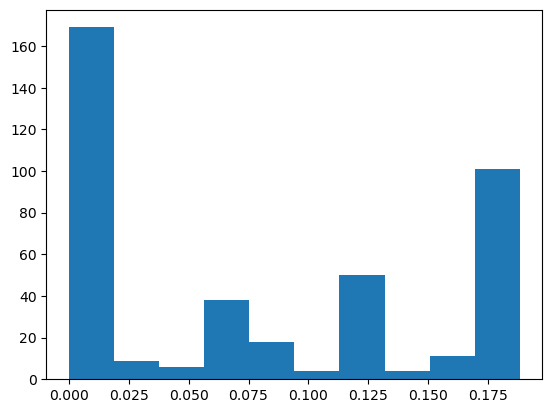

In [6]:
plt.hist(df['gap'])

In [7]:
df.isna().sum()

sheet          0
chain          0
co_owned       0
state          0
southj         0
centralj       0
northj         0
pa1            0
pa2            0
shore          0
ncalls         0
empft          6
emppt          4
nmgrs          6
wage_st       20
inctime       31
firstinc      43
bonus          0
pctaff        44
meals          0
open           0
hrsopen        0
psoda          8
pfry          17
pentree       12
nregs          6
nregs11       12
type2          0
status2        0
date2          0
ncalls2      249
empft2        12
emppt2        10
nmgrs2         6
wage_st2      21
inctime2      66
firstin2      80
special2      18
meals2        11
open2r        11
hrsopen2      11
psoda2        22
pfry2         28
pentree2      24
nregs2        22
nregs112      27
pre_fte       12
post_fte      14
delta_fte     26
gap            0
chain1         0
chain2         0
chain3         0
chain4         0
dtype: int64

In [8]:
df_clean = df.dropna(subset=['delta_fte', 'co_owned', 'chain2', 'chain3', 'chain4', 'inctime', 'firstinc', 'bonus', 'pctaff', 'meals', 'open', 'hrsopen', 'psoda', 'pfry', 'pentree', 'inctime2', 'firstin2', 'special2', 'meals2', 'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2', 'gap'])

In [9]:
df_clean.to_csv("cleaned_dataset.csv", index=False)

In [10]:
# Covariates for the DMLDiD procedure
X = df_clean[['co_owned', 'chain2', 'chain3', 'chain4',
              'inctime', 'firstinc', 'bonus', 'pctaff', 'meals', 'open', 'hrsopen', 'psoda', 'pfry', 'pentree', 
              'inctime2', 'firstin2', 'special2', 'meals2', 'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# The outcome variable (delta employment change)
Y = df_clean['delta_fte'].values

# Treatment variable (1 in NJ, 0 in PA)
D = df_clean['gap'].values

In [11]:
print(X.shape)
print(Y.shape)
print(D.shape)

(227, 23)
(227,)
(227,)


In [12]:
class neural_net(nn.Module):
    def __init__(self, input_size):
        super(neural_net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001
K = 5  # Number of folds

In [14]:
# Store intermediate ATT estimates
theta_k = []
# store all scores
all_scores = []
ps_train_losses, ps_val_losses = [], []  # Track propensity score losses
outcome_train_losses, outcome_val_losses = [], []  # Track outcome losses

In [15]:
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [16]:
# Generate B-spline basis for continuous treatment
def bspline_basis(D, df=3, degree=3):
    return dmatrix(f"bs(D, df={df}, degree={degree}, include_intercept=False)", {"D": D}, return_type='dataframe')

# Placeholder for ATT estimates
att_curve = []

# Grid of treatment levels for the ATT curve
D_grid = np.linspace(min(df['gap']), max(df['gap']), 5)

ps_train_losses = []
ps_val_losses = []
outcome_train_losses = []
outcome_val_losses = []

for d_value in D_grid:
    residual_scores = []

    for train_index, val_index in kf.split(X_scaled):
        # Split the data into train and validation sets
        X_train, X_val = X[train_index], X[val_index]
        D_train, D_val = D[train_index], D[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        D_train_tensor = torch.tensor(D_train, dtype=torch.float32).unsqueeze(1)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
        
        # Step 1: Train the neural network for propensity score (treatment residual)
        ps_model = neural_net(X_train.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(ps_model.parameters(), lr=learning_rate)
        
        ps_epoch_train_losses = []
        ps_epoch_val_losses = []
        
        for epoch in range(num_epochs):
            ps_model.train()
            optimizer.zero_grad()
            ps_output = ps_model(X_train_tensor)
            train_loss = criterion(ps_output, D_train_tensor)
            train_loss.backward()
            optimizer.step()
            
            # Record training loss
            ps_epoch_train_losses.append(train_loss.item())

            # Compute validation loss
            ps_model.eval()
            with torch.no_grad():
                ps_val_output = ps_model(X_val_tensor)
                val_loss = criterion(ps_val_output, torch.tensor(D_val, dtype=torch.float32).unsqueeze(1))
                ps_epoch_val_losses.append(val_loss.item())
        
        # Append epoch losses to overall lists
        ps_train_losses.append(ps_epoch_train_losses)
        ps_val_losses.append(ps_epoch_val_losses)

        # Predict treatment residuals
        with torch.no_grad():
            m_hat = ps_model(X_val_tensor).numpy()
            treatment_residuals = D_val - m_hat.squeeze()
        
        # Step 2: Train the neural network for outcome model
        outcome_model = neural_net(X_train.shape[1] + 4)  # Include spline features
        optimizer = optim.Adam(outcome_model.parameters(), lr=learning_rate)
        
        outcome_epoch_train_losses = []
        outcome_epoch_val_losses = []
        
        for epoch in range(num_epochs):
            outcome_model.train()
            optimizer.zero_grad()
            
            # Generate spline basis for training
            bs_train = bspline_basis(D_train)
            bs_train_tensor = torch.tensor(bs_train.to_numpy(), dtype=torch.float32)
            outcome_input_train = torch.cat([X_train_tensor, bs_train_tensor], dim=1)
            
            outcome_output = outcome_model(outcome_input_train)
            train_loss = criterion(outcome_output, Y_train_tensor)
            train_loss.backward()
            optimizer.step()
            
            # Record training loss
            outcome_epoch_train_losses.append(train_loss.item())

            # Compute validation loss
            outcome_model.eval()
            with torch.no_grad():
                bs_val = bspline_basis(D_val)
                bs_val_tensor = torch.tensor(bs_val.to_numpy(), dtype=torch.float32)
                outcome_input_val = torch.cat([X_val_tensor, bs_val_tensor], dim=1)
                val_output = outcome_model(outcome_input_val)
                val_loss = criterion(val_output, torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1))
                outcome_epoch_val_losses.append(val_loss.item())
        
        # Append epoch losses to overall lists
        outcome_train_losses.append(outcome_epoch_train_losses)
        outcome_val_losses.append(outcome_epoch_val_losses)

        # Predict outcome residuals
        with torch.no_grad():
            g_hat = outcome_model(outcome_input_val).numpy()
            outcome_residuals = Y_val - g_hat.squeeze()
        
        residual_score = np.mean(outcome_residuals * (treatment_residuals - d_value))
        residual_scores.append(residual_score)

    # Average the scores over folds
    tau_d = np.mean(residual_scores)
    att_curve.append(tau_d)

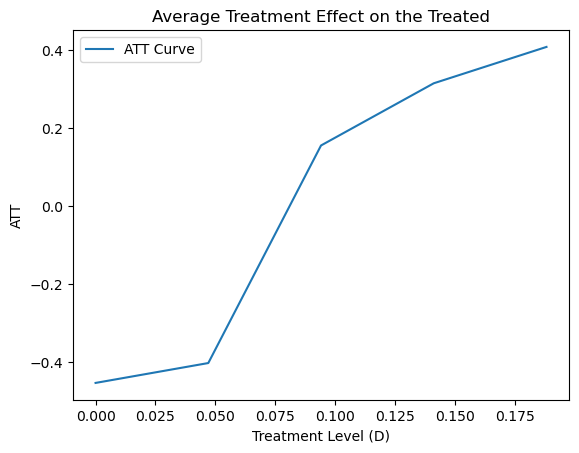

In [17]:
plt.plot(D_grid, att_curve, label="ATT Curve")
plt.xlabel("Treatment Level (D)")
plt.ylabel("ATT")
plt.title("Average Treatment Effect on the Treated")
plt.legend()
plt.show()

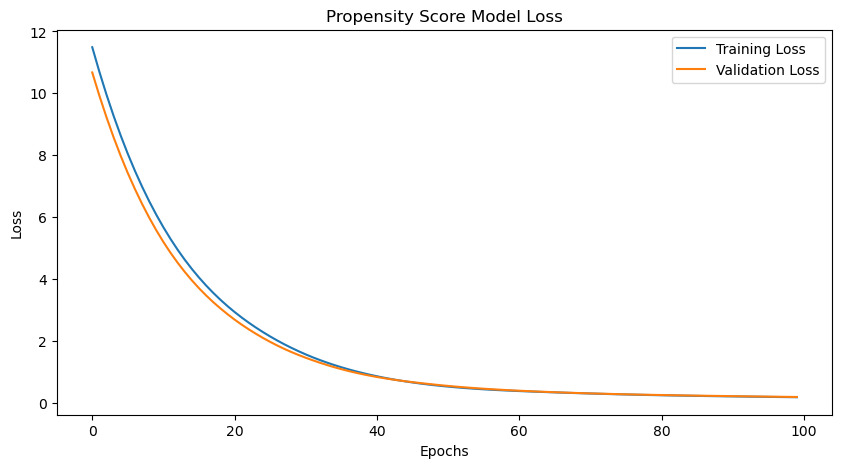

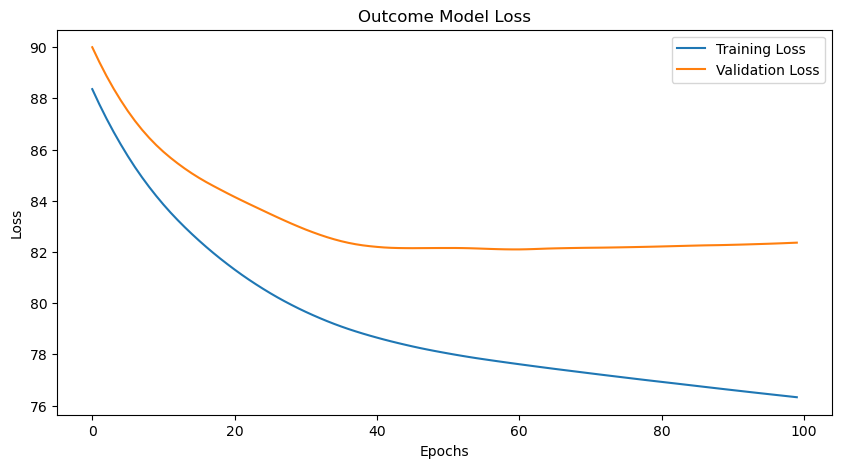

In [18]:
# Plotting Training and Validation Losses
def plot_loss(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(train_losses, axis=0), label='Training Loss')
    plt.plot(np.mean(val_losses, axis=0), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize losses
plot_loss(ps_train_losses, ps_val_losses, 'Propensity Score Model Loss')
plot_loss(outcome_train_losses, outcome_val_losses, 'Outcome Model Loss')

'''how to decide b-spline's degree of freedom and degree of polinomio to use'''
'''how is the b-spline interact with outcome prediction model'''